# Rayleigh projection depth experiments

In [1]:
import project_path
from src.util.tensor_projection_depth import tensor_outlying_function, vector_outlying_score
from src.util.gen_lr_smooth_data import gen_lr_smooth_data
from scipy.linalg import eig, eigh
from src.util.graph import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy.stats import multivariate_normal
from tqdm import tqdm

## Two dimensional vector outlying function test
Generate two sets of two dimensional multivariate gaussian samples drawn from distinct distributions. Call one set the anomaly samples and other the normal ones. Using the samples at hand, find the empirical outlying score and calculate the AUC score.

In [41]:
nos = 1000
annos =100
rng = np.random.default_rng(0)
cov = np.array([[3,1.5],[1.5,3]])
cov2 = np.array([[5,-1],[-1,2]])
mean = np.array([1,-1])
mean2= np.array([-2,2])
sn = rng.multivariate_normal(mean,cov,nos).T
an = rng.multivariate_normal(mean2,cov2,annos).T
of = np.zeros((nos,1))
af = np.zeros((annos,1))
for i in range(nos):
    of[i] = 1/(1+vector_outlying_score(sn[:,i],np.concatenate((sn,an),1)))
for i in range(annos):
    af[i] = 1/(1+vector_outlying_score(an[:,i],np.concatenate((sn,an),1)))


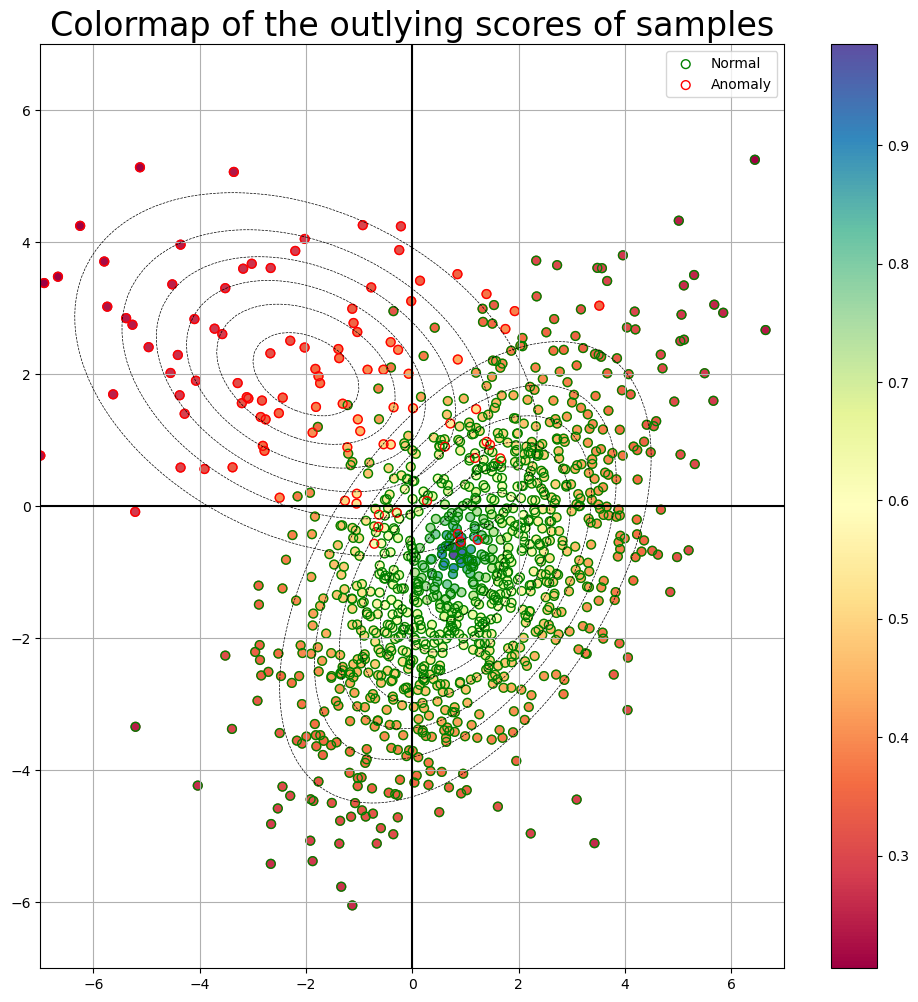

In [56]:
sizelim = 7
N = 100
X = np.linspace(-sizelim, sizelim, N)
Y = np.linspace(-sizelim, sizelim, N)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))
rv = multivariate_normal(mean, cov)
rv2 = multivariate_normal(mean2, cov2)
Z  = rv.pdf(pos)
Z2 = rv2.pdf(pos)
# plt.style.use('default')
fig, axe = plt.subplots(1,1, figsize=(12,12))
axe.contour(X, Y, Z,linestyles='dashed',colors='k' ,linewidths=0.5)
axe.contour(X, Y, Z2,linestyles='dashed',colors='k',linewidths=0.5)
n = axe.scatter(sn[0,:],sn[1,:],s=40, c=of, cmap='Spectral')
fig.colorbar(n, ax=axe)
axe.scatter(an[0,:],an[1,:],s=40, c=af, cmap='Spectral')
axe.scatter(sn[0,:],sn[1,:],s=40, facecolors='none',alpha=1, edgecolors='g',label='Normal')
axe.scatter(an[0,:],an[1,:],s=40, facecolors='none',alpha=1, edgecolors='r',label='Anomaly')
axe.vlines(0,ymin=-sizelim,ymax=sizelim,colors='k')
axe.hlines(0,xmin=-sizelim,xmax=sizelim,colors='k')
axe.set_xlim(-sizelim,sizelim)
axe.set_ylim(-sizelim,sizelim)
axe.set_title('Colormap of the outlying scores of samples',size=24)
axe.grid()
axe.legend()


Mean outlying score of normal data: 0.51333	 Anomalous data:0.34413
AUC-ROC score = 0.83184


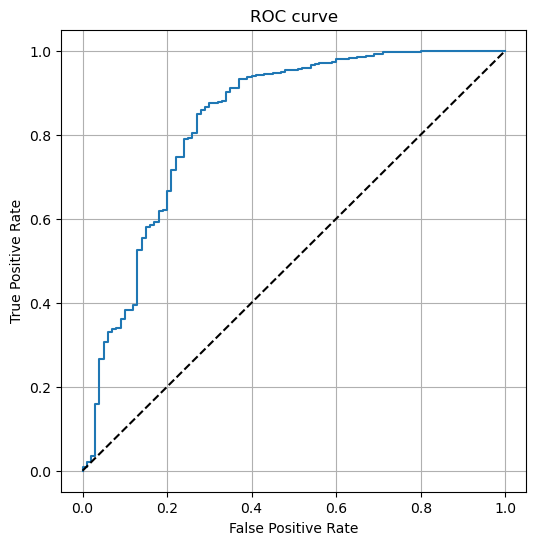

In [43]:
print(f"Mean outlying score of normal data: {np.mean(of):.5f}\t Anomalous data:{np.mean(af):.5f}")
y = np.ones((nos+annos,1))
pred = np.zeros((nos+annos,1))
pred[:nos] = of
pred[nos:] = af
y[nos:]=0
fpr, tpr, thresholds = metrics.roc_curve(y,pred,pos_label=1)
print(f"AUC-ROC score = {metrics.auc(fpr,tpr):.5f}")
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",);
ax.grid()

## Testing the Separability of smooth graph signals via rayleigh projection depth


In [2]:
rand_graph_params = {'dim': 6,'type': 'ba','g_params': 1}
G1 = Graph(rand_graph_params=rand_graph_params)
G2 = Graph(rand_graph_params=rand_graph_params)
GP1 = GraphProcess(Graph=G1, filter_type='Heat',filter_parameters=5)
GP2 = GraphProcess(Graph=G2, filter_type='Heat',filter_parameters=5)

Mean outlying score of normal data: 0.31249	 Anomalous data:0.06454
AUC-ROC score = 0.98550


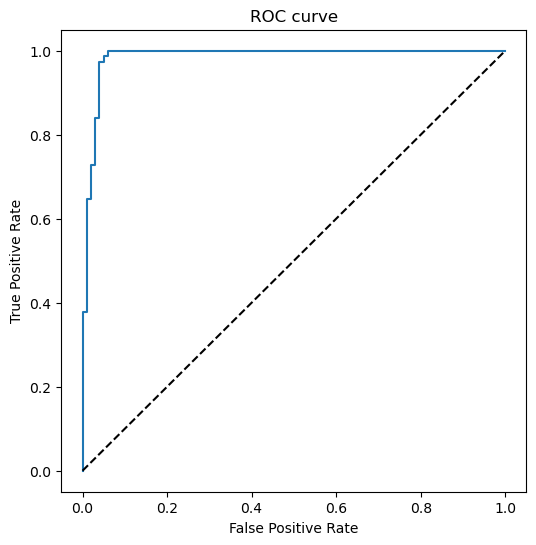

In [63]:
nos = 1000; annos=100
signal = GP1.gen_signal(nos,0)
sn = signal['X']
anomaly = GP2.gen_signal(annos,0)
an = anomaly['X']
all_samples = np.concatenate((sn,an),axis=1)
of = np.zeros((nos,1))
af = np.zeros((annos,1))
for i in range(nos):
    of[i] = 1/(1+vector_outlying_score(sn[:,i],sn))
for i in range(annos):
    af[i] = 1/(1+vector_outlying_score(an[:,i],sn))

print(f"Mean outlying score of normal data: {np.mean(of):.5f}\t Anomalous data:{np.mean(af):.5f}")
y = np.ones((nos+annos,1))
pred = np.zeros((nos+annos,1))
pred[:nos] = of
pred[nos:] = af
y[nos:]=0
fpr, tpr, thresholds = metrics.roc_curve(y,pred,pos_label=1)
print(f"AUC-ROC score = {metrics.auc(fpr,tpr):.5f}")
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
);

In [36]:
rand_graph_params = {'dim': 20,'type': 'er','g_params': 0.2}
factor_graph_params = [rand_graph_params,rand_graph_params]
kwargs = {
        'factor_graph_params': factor_graph_params,
        'product_type': 'cart'
        }

PG = ProductGraph(**kwargs)
PG2 = ProductGraph(**kwargs)
GP = GraphProcess(Graph=PG, filter_type='Heat',filter_parameters=10)#'Smooth non-stationary')
GP2 = GraphProcess(Graph=PG2, filter_type='Heat',filter_parameters=10)#'Smooth non-stationary')

In [37]:
noa = 20; nos =100
signal = GP.gen_signal(nos,0)
Xs = signal['X']
anomaly = GP2.gen_signal(noa,0)
Zs = [anomaly['X'][...,i] for i in range(anomaly['X'].shape[-1])]
Nn = [Xs[...,i] for i in range(Xs.shape[-1])]
Sn = Nn
a_of = np.zeros(noa)
normal_of = np.zeros(nos)
for i in tqdm(range(len(Zs))):
    a_of[i], o_l=  tensor_outlying_function(Zs[i], Sn, maxit=200, err_tol=1e-3, v=0, seed=10, return_Us=False)
for i in tqdm(range(len(Nn))): 
    normal_of[i], o_l=  tensor_outlying_function(Nn[i], Sn, maxit=200, err_tol=1e-3, v=0, seed=10, return_Us=False)

100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


Mean Anomaly projection depth score: 2.798781103613867
Mean Normal projection depth score: 3.005127372504743


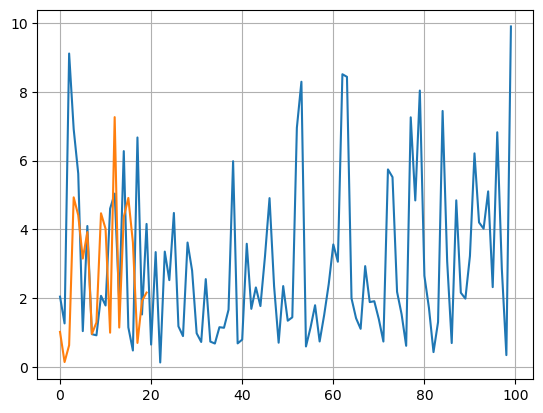

In [38]:
fig, axe = plt.subplots(1,1)
axe.plot(normal_of)
axe.plot(a_of)
#axe.plot(o_l)
axe.grid()
print(f"Mean Anomaly projection depth score: {np.mean(a_of)}")
print(f"Mean Normal projection depth score: {np.mean(normal_of)}")

Mean outlying score of normal data: 1.38367	 Anomalous data:1.45139
AUC-ROC score = 0.50800


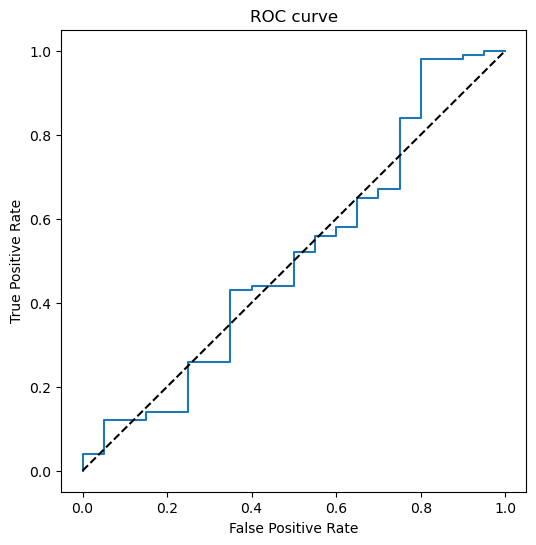

In [40]:
print(f"Mean outlying score of normal data: {np.mean(a_of):.5f}\t Anomalous data:{np.mean(normal_of):.5f}")
y = np.ones((nos+noa,1))
pred = np.zeros((nos+noa,))
pred[:nos] = normal_of.ravel()
pred[nos:] = a_of.ravel()
y[nos:]=0
fpr, tpr, thresholds = metrics.roc_curve(y,pred,pos_label=1)
print(f"AUC-ROC score = {metrics.auc(fpr,tpr):.5f}")
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
);

In [22]:
rand_graph_params = {'dim': 10,'type': 'er','g_params': 0.2}
factor_graph_params = [rand_graph_params,rand_graph_params,rand_graph_params]
kwargs = {
        'factor_graph_params': factor_graph_params,
        'product_type': 'cart'
        }

PG = ProductGraph(**kwargs)
PG2 = ProductGraph(**kwargs)

In [33]:
noa = 100
nos =100
Zs = [gen_lr_smooth_data((10,10,10), (10,10,10), PG2, filter='Heat', alpha=10) for i in range(noa)]
Nn = [gen_lr_smooth_data((10,10,10), (10,10,10), PG, filter='Heat', alpha=10) for i in range(nos)]
Sn = Nn
a_of = np.zeros(noa)
normal_of = np.zeros(nos)

for i in tqdm(range(len(Zs))):
    a_of[i], o_l=  tensor_outlying_function(Zs[i], Sn, maxit=200, err_tol=1e-3, v=0, seed=10, return_Us=False)
    a_of[i] = 1/(1+a_of[i])
for i in tqdm(range(len(Nn))): 
    normal_of[i], o_l= tensor_outlying_function(Nn[i], Sn, maxit=200, err_tol=1e-3, v=0, seed=10, return_Us=False)
    normal_of[i] = 1/(1+normal_of[i])

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


Mean Anomaly projection depth score: 0.41937904082466737
Mean Normal projection depth score: 0.38695350005079215
AUC-ROC score = 0.44410


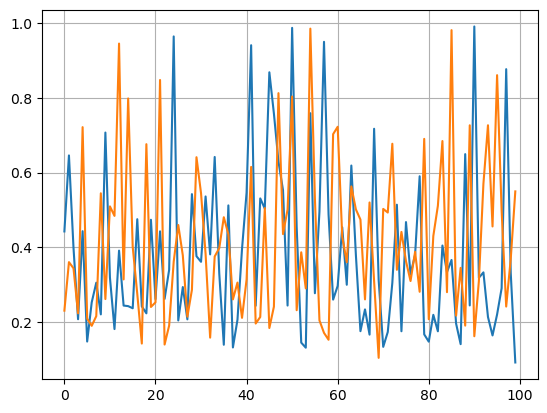

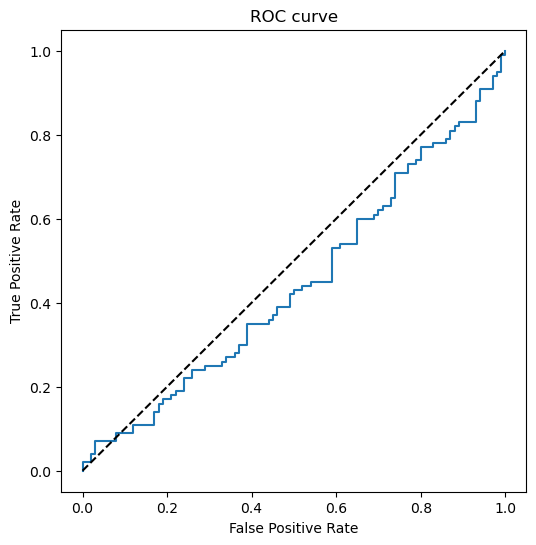

In [34]:
fig, axe = plt.subplots(1,1)
axe.plot(normal_of)
axe.plot(a_of)
#axe.plot(o_l)
axe.grid()
print(f"Mean Anomaly projection depth score: {np.mean(a_of)}")
print(f"Mean Normal projection depth score: {np.mean(normal_of)}")
y = np.ones((nos+noa,1))
pred = np.zeros((nos+noa,))
pred[:nos] = normal_of.ravel()
pred[nos:] = a_of.ravel()
y[nos:]=0
fpr, tpr, thresholds = metrics.roc_curve(y,pred,pos_label=1)
print(f"AUC-ROC score = {metrics.auc(fpr,tpr):.5f}")
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr,tpr)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="ROC curve",
);